# Solar Geoengineering Practical

In this practical we will analyze the climate response to stratospheric aerosol geoengineering using results from the Geoengineering Large Ensemble (GLENS) runs. You can find out more about the GLENS runs here: https://journals.ametsoc.org/doi/full/10.1175/BAMS-D-17-0267.1

By following the steps described below you will learn how to make certain plots and analyses that you can then apply to your region. 

## 1. load modules
If there are any errors here, you should go back to the instructions in the readme, and check that you have followed them correctly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
from pathlib import Path

In [9]:
from platform import python_version

print(python_version())

3.7.6


## 2. Some file definitons
Now we create some file and other definitions that we will use later.

In [2]:
"""
We have 5 variables:
TREFHT = Temperature at the reference height (2m), i.e. air temperature
TREFHTMX = The maximum recorded air temperature in a month
PRECT = Precipitation rate (rain + snow)
PRECTMX = The maximum recorded precipitation rate at the model timestep (30 mins)
P-E = Precipitation minus total Evaporation (evaporation, transpiraton and sublimation)
"""

variables = ['TREFHT', 'TREFHTMX', 'PRECT', 'PRECTMX', 'P-E']
variable_shorthand = ['T','Tmax','P','Pmax','P-E']
units_orig = ['K','K','m/s','m/s','m/s'] # m/s is not an easy-to-interpret unit so we will convert this later.

"""
There are two experiments, and two files for each variable:
Control - starts in the year 2010 with GHG emissions following a high-end, rapid-warming scenario
Feedback - starts in the year 2020 with the same GHG scenario as Control but with stratospheric aerosol 
geoengineering deployed to keep temperatures at 2020 levels, see the paper linked to at the start for more.
"""
control_name = 'control.001.cam.h0.{VAR}.201001-209912.{SEAS}.nc'
feedback_name = 'feedback.001.cam.h0.{VAR}.202001-209912.{SEAS}.nc'

# this specifies the path to the data, using "/" to separate folders, and it should work in both mac and linux.
data_dir = Path("data/")

# Now we're going to open a test file. If this doesn't open, edit "data_dir" so that the path matches where your data is stored.
control_filename = data_dir / control_name.format(VAR='TREFHT', SEAS='ann') 
control_nc = Dataset(control_filename)

# Now we define the latitudes, longitudes, and the time_control variables. Now that they have been defined, we can use them later for plotting.
lats = control_nc.variables['lat'][:]
lons = control_nc.variables['lon'][:]
time_control = control_nc.variables['time'][:]

# Now, let's test the data.
control_T = control_nc.variables['TREFHT']
print(control_T)

# You should see a few lines of text describing the TREFHT variable within the netcdf file that we opened. 
# Note the "shape" of the data, and the order of the dimensions: (time, lat, lon) = (90, 192, 288)
# This means that time is the first dimension and there are 90 years, 192 latitudes, 288 longitudes.

<class 'netCDF4._netCDF4.Variable'>
float32 TREFHT(time, lat, lon)
    long_name: Reference height temperature
    units: K
    cell_methods: time: mean
unlimited dimensions: time
current shape = (90, 192, 288)
filling off


# 2.1. Next we create a function to select years 

In [3]:
def sel_years(data, years_list, ctrl=True):
    """
    Inputs:
    Var = netcdf 3D variable, e.g. TREFHT
    years_list = list of years to include, 2020 = 20, 2021 = 21, etc.
    months_list = list of months to include, Jan = 1, Feb = 2, etc.
    ctrl = True for control experiment, False for feedback experiment
    Output:
    Only those months in data which meet the criteria
    """
    
    # For the time index, the first entry has to start at 0 in each experiment (python counts from zero).
    # Subtract 10 years for ctrl or 20 years for feedback
    y_offset = -10 if ctrl else -20 
    years_array = np.array(years_list) + y_offset
    
    # This loops through all years selected to create a list of indices for the months to be included
    time_indices = np.array([YEAR for YEAR in years_array])
    print('Check first 20 indices as expected:',time_indices[0:19])
    
    return data[time_indices,:,:]

## 3. Gathering data for our first plot
Let's look at air temperature first and see how temperature has changed from today in the two experiments.

In [4]:
# "var" will stand in for "TREFHT" below
var = 'TREFHT'
# We will focus on the annual-mean to start with, but you could look at djf, mam, jja, or son (Northern winter, spring, etc.)
season = 'ann'

# First let's get the control data
control_filename = data_dir / control_name.format(VAR=var, SEAS=season) # Define the filename for the control-variable netcdf
control_nc = Dataset(control_filename) # Open the netcdf
control_data = control_nc.variables[var][:] # Extract the data, a 3-D array of temperature values, from the netcdf variable

# Then do the same for the feedback data
feedback_filename = data_dir / feedback_name.format(VAR=var, SEAS=season)
feedback_nc = Dataset(feedback_filename)
feedback_data = feedback_nc.variables[var][:]

In [5]:
"""
Here I define 3 different cases that I will compare:
Control 2010 - 2029: This is a 20-year reference period, which is effectively the climate of today
Control 2070 - 2089: This is a 20-year period late in the century representative of the changes in the extreme global warming scenario
Feedback 2070 - 2089: This is the same 20-year period late in the century and is representative of the changes in the geoengineering scenario
"""

"""
These lines use the "sel_time()" function to select all the years that we want to look at.
In this case I want to look at all years between 2070 (70, here) and 2089. 
This code: "[70 + i for i in range(20)]" makes a list of 20 years that runs from 70 to 89. 
"""
data_ctrl_10_29 = sel_years(control_data, [10 + i for i in range(20)], ctrl=True)
data_ctrl_70_89 = sel_years(control_data, [70 + i for i in range(20)], ctrl=True)
data_fdbk_70_89 = sel_years(feedback_data, [70 + i for i in range(20)], ctrl=False) # ctrl = False as this is feedback!

# Now I take a mean over the whole period for each case (Time is axis 0)
data_ctrl_10_29_mean = np.mean(data_ctrl_10_29, axis=0)
data_ctrl_70_89_mean = np.mean(data_ctrl_70_89, axis=0)
data_fdbk_70_89_mean = np.mean(data_fdbk_70_89, axis=0)

"""
The sel_time code spits out the first 20 time indices you've selected. The time index starts at 0 in the first month of each experiment.
As Control starts in 2010, so the index starts at 0, and at 2070 it should be 60
Feedback starts in 2020, so the first index should be: 50 
"""


Check first 20 indices as expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Check first 20 indices as expected: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78]
Check first 20 indices as expected: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]


"\nThe sel_time code spits out the first 20 time indices you've selected. The time index starts at 0 in the first month of each experiment.\nAs Control starts in 2010, so the index starts at 0, and at 2070 it should be 60\nFeedback starts in 2020, so the first index should be: 50 \n"

## 4. Now let's make some map plots
We'll be using basemap to make map plots and it's slightly fiddly, so first let's tidy those fiddly bits into a function 

In [6]:
"""
This function takes in lons, lats, and some 2D data (like our time-mean data) and transforms their coordinates to
match the specific map projection we will use, stored in the variable m. Once this function has been defined we don't
need to run this section again. See below for usage.
"""
def map_transform(m, lons, lats, data_2d):
    # Make the plot continuous
    map_data, lons_cyclic = addcyclic(data_2d, lons)
    # Shift the grid so lons go from -180 to 180 instead of 0 to 360.
    map_data, lons_cyclic = shiftgrid(180., map_data, lons_cyclic, start=False)
    # Create 2D lat/lon arrays for Basemap
    lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
    # Transforms lat/lon into plotting coordinates for projection
    x, y = m(lon2d, lat2d)
    return x, y, map_data

C:\Users\pjirv\Anaconda3\envs\GEOL0013_geoengineering\lib\site-packages\numpy\ma\core.py:3188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


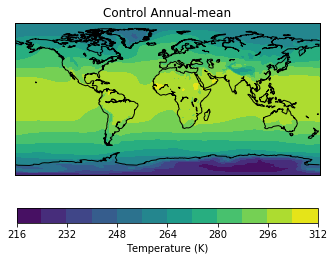

In [7]:
"""
Now, let's plot a global map of temperature for the reference period
"""

fig = plt.figure()
# fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
# If you'd like there are lots of other projections you can use, see: http://matplotlib.org/basemap/users/mapsetup.html
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0)

# Let's draw coastlines and the map boundary
m.drawcoastlines()
m.drawmapboundary()
# when you zoom in on your region, you might want to uncomment the following:
# m.drawcountries()
# m.drawrivers()

# Here we use that function we defined earlier
x, y, map_data = map_transform(m, lons, lats, data_ctrl_10_29_mean)
    
# Plot of air temperature with 11 contour intervals, using the "color map" viridis.
cs = m.contourf(x, y, map_data, 11, cmap=plt.cm.viridis)
cbar = plt.colorbar(cs, orientation='horizontal', shrink = 0.9, extend='both')

# Now we label the plot and colorbar
plt.title('Control Annual-mean')
cbar.set_label('Temperature (K)')

# Now let's save the file into our folder, and then display it
plt.savefig('reference_T.png', format='png', dpi=300)
plt.show()

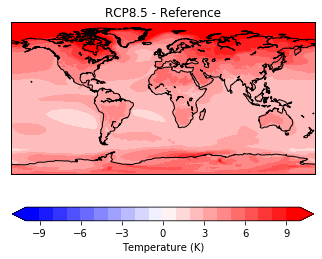

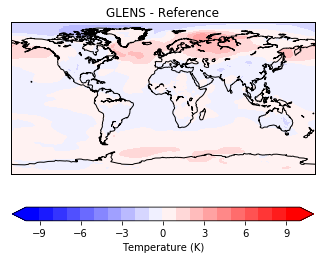

In [8]:
"""
Now, let's plot the difference between this reference case and the two future cases
"""

# First we take the differences
ctrl_anom = data_ctrl_70_89_mean - data_ctrl_10_29_mean
fdbk_anom = data_fdbk_70_89_mean - data_ctrl_10_29_mean

# Next plot the global warming case (ctrl_anom) 
fig = plt.figure()

m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()

# Same function as before but different data
x, y, map_data = map_transform(m, lons, lats, ctrl_anom)
    
# Now, we're going to specify the bounds for our color bar rather than letting it be generated automatically.
bounds = np.linspace(-10,10,21) # this just creates a list of 21 numbers from -10, to 10.
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# I've chosen a diverging colormap as we're looking at both positive and negative anomalies. See here for more colorbar options:
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
cs = m.contourf(x, y, map_data, 11, norm=norm, cmap=plt.cm.bwr, levels=bounds, extend='both')
cbar = plt.colorbar(cs, orientation='horizontal', shrink = 0.9, extend='both')

# Now we label the plot and colorbar. Let's name it after the GHG scenario its based on: "RCP8.5"
plt.title('RCP8.5 - Reference')
cbar.set_label('Temperature (K)')

# Now let's save the file into our folder, and then display it
plt.savefig('RCP85_ref_anom_T.png', format='png', dpi=300)
plt.show()

"""
Next plot the geoengineering case
"""
fig = plt.figure()

m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()

# Same function as before but different data
x, y, map_data = map_transform(m, lons, lats, fdbk_anom)
    
# Now, we're going to specify the bounds for our color bar rather than letting it be generated automatically.
bounds = np.linspace(-10,10,21) # this just creates a list of 21 numbers from -10, to 10.
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(x, y, map_data, 11, norm=norm, cmap=plt.cm.bwr, levels=bounds, extend='both')
cbar = plt.colorbar(cs, orientation='horizontal', shrink = 0.9, extend='both')

# Now we label the plot and colorbar. Let's name it after the geoengineering experiment name "GLENS"
plt.title('GLENS - Reference')
cbar.set_label('Temperature (K)')

# Now let's save the file into our folder, and then display it
plt.savefig('GLENS_ref_anom_T.png', format='png', dpi=300)
plt.show()

Check in the folder that the jupyter notebook is running and you should see some nice, high quality png files that you could copy into your reports.

# 5. Now try for yourself to produce a regional map

1. Copy the code which produced the global map of temperature for the reference period into the box below.
2. Next, edit the line which calls the "Basemap" function and change the 4 variables that specify the map extent to select an area around your country, don't make your box smaller than 20 x 20 degrees. Hint: llcrnrlat = lower-left corner latitude.
3. Edit the title and filename so you don't overwrite the original, then run. It may take a few tries to get lon-lat box centred nicely.

# 6. Now, let's work with the hydrological variables.

1. First, Copy the the boxes of code from section 3 to below this box (the + symbol at the top creates new boxes, and the scissors delete them). If you've understood the comments, feel free to delete them below.
2. Next, edit the code to change the variable from TREFHT to PRECT. Remember to change the filename or you will overwrite the original 
3. The hydrological variables are all in inconvenient units of m/s so let's convert them to mm/day. Create a variable that converts m/s to mm/day in the second box. It should look something like this (with a different number): "to_mm_day = 999999.99999"
4. Where we define control_data and feedback_data multiply the right hand side by this new conversion factor variable.
5. Run your edited text boxes.
6. Now, copy your regional plot routine from above, edit it, and run it to show your hydrological variable in your region.

## 7. Hydrological anomaly plots

1. Copy the code box from section 4 that plotted the temperature anomaly plots to the space below. As section 6 redefined variables like "data_ctrl_70_89_mean" with precipitation data, this code will now produce anomaly plots for precipitation instead of temperature. This means you have to be careful to run them in the right order!
2. Make the same edits as before to redefine the map to focus on your region.
3. Edit the code to update the labels, titles and filenames of both plots to fit this new setup, then run the code.
4. Oh no! the color scale is weird and places getting wetter are red. Edit the "bounds" line to give it a more reasonable range and number of steps. you can manually specify the boundaries using a line like this: "bounds = np.array([-3,-2,-1,0,1,2,3])"
5. Let's also change to a different color scale, replace "cmap=plt.cm.bwr" with "cmap=plt.cm.RdBu" so blue is wet and red is dry. There are others here if you'd like to pick something else: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

# 8. Now, start your own analysis!

1. Open the "country_name.ipynb" jupyter notebook, rename it to your country, and enter your student numbers.
2. I've filled out the "code to run once section", copying over those parts of the code here that only need to be run once.
3. Now you can start copying over and editing the code from this example notebook to start building your own notebook to analyze the climate response in your country. 
4. Do some analysis of what you believe to be the most relevant changes in your region (you won't be able to look at everything), drawing on some of the EXTRAS I show below.
5. Once you're done, you should make sure that your code runs correctly, i.e. if you restart it then run each code box in order it should produce all the figures and results that you think it should. I will run the code on my computer and you will be marked down if it doesn't work. Including "markdown" sections, like this one, or comments in the code will help make it clear what your code is doing which will help me and help you too.

Note: remember to update the filenames when you produce new plots or you will overwrite your old ones!

Note: You have to run the sections in the right order so to plot maps for both temperature and precipitation and calculate their regional means (shown below) your code will have the following sections:
1. code based on section 3 to load temperature
2. code based on section 4 to plot temperature
3. code based on section Extra-4 to calculate mean temperature
4. code based on section 3 to load precipitation
5. code based on section 4 to plot precipitation
6. code based on section Extra-4 to calculate mean precipitation

# Extras!
Below I give you a few more ideas and tools to extend your analysis.

## Extra 1. Percentage change
It is sometimes useful to look at changes in hydrological variables in percentage terms (not useful for temperature). Beware though that in dry places this could blow up as you could be dividing by almost zero.

Simply edit the lines which specify the anomalies ("ctrl_anom = ...") to instead calculate the percentage change: * = multiply, / = divide, etc.

## Extra 2. Different seasons

Instead of looking at changes in the annual-mean (or maximum) you could see how things are changing in different seasons. This is straightforward; simply reproduce the code from sections 3 and 4 but change the variable "season" from "ann" to "djf", "mam", "jja" or "son".

You could also look at the seasonality, e.g. taking the difference between jja and djf for each case. All you'll need to do is define a new seasonality variable after you've calculated the time-means, and then you could check the difference between the seasonalities of the RCP8.5, GLENS and Reference cases to see how things are changing. 

NOTE: for djf, the first winter includes only january and February so you might want to shift things back by a year using the selyear function.

## Extra 3. change in terms of number of standard deviations

Some climate variables in some regions vary a lot from year to year and it is interesting to look at how any changes you find compare to this variability. To do so you could use the following code to calculate the standard deviation in the reference period and then divide the anomalies you find by this value.

In [23]:
# just after you calculate the time-mean in Section 3, you could calculate the standard deviation over time for the reference period:
data_ctrl_10_29_mean = np.mean(data_ctrl_10_29, axis=0)
data_ctrl_10_29_std = np.std(data_ctrl_10_29, axis=0)

# then in section 4 when we define the anomalies you could instead divide them by this value:
ctrl_anom_std = (data_ctrl_70_89_mean - data_ctrl_10_29_mean) / data_ctrl_10_29_std
fdbk_anom_std = (data_fdbk_70_89_mean - data_ctrl_10_29_mean) / data_ctrl_10_29_std

## Extra 3. Fractional geoengineering

The GLENS experiment offsets all warming from 2020 which might result in an overshoot in your region for some measures. The following code, to be run after the section 3 code loads the data and takes the time-means, produces a simple estimate of the climate response in a scenario with less geoengineering using a simple linearity assumption.

In [22]:
# First rename the data to make things clearer
data_ref = data_ctrl_10_29_mean
data_RCP85 = data_ctrl_70_89_mean
data_GLENS = data_fdbk_70_89_mean

fraction = 0.5 # you could change this to some other fraction and change the name below if you like.
"""
This function simply linearly scales the data at each latitude and longitude to be some fraction of the way
from the value in the RCP8.5 scenario towards the value in the GLENS scenario. 
If fraction is 0, we return data_RCP8.5, and if the fraction is 1 we return data_GLENS
"""
data_half_GLENS = data_RCP85 - fraction * (data_GLENS - data_RCP85)

## Extra 4. Regional-means and weighting

You could take the mean over your region. 

Hint: you can use the regional plot to work out the boundaries you want by adjusting them until they match the area you want to take the mean over and then use those values here. However, you have to specify longitudes between 0 and 360 and can't straddle the meridian.

In [ ]:
"""
First we define a function to select a lon-lat box.
"""
def select_lon_lat_box(data_2d, lons, lats, lower_lat, upper_lat, lower_lon, upper_lon):
    # Note you have to specify longitudes between 0 and 360 and can't straddle the meridian.
    
    # latitude lower and upper index
    latli = np.argmin( np.abs( lats - lower_lat ) )
    latui = np.argmin( np.abs( lats - upper_lat ) ) 

    # longitude lower and upper index
    lonli = np.argmin( np.abs( lons - lower_lon ) )
    lonui = np.argmin( np.abs( lons - upper_lon ) )  

    # Return just that part within the bounds
    return data_2d[latli:latui,lonli:lonui]

In [123]:
"""
Next we load a file that specifies the fractional area of each gridcell (those near the poles are smaller than those at the equator)
And load up a land area fraction for the model, i.e. what fraction of the gridcell is land as opposed to water.
"""

# Load up the gridcell weights (fraction of global area)
area_weight_filename = data_dir / 'area_weight.nc' 
area_weight_nc = Dataset(area_weight_filename) 
area_weight_data = area_weight_nc.variables['cell_weights'][:]

# Load up the land fraction data
land_frac_filename = data_dir / 'land_fraction.nc' 
land_frac_nc = Dataset(land_frac_filename) 
land_frac_data = 0.01 * land_frac_nc.variables['sftlf'][:] # convert from percent to fraction

# Multiply to find the land weighting
land_weight = area_weight_data * land_frac_data

"""
I've also included data for agriculture fraction and population count so you could weight by these instead. Open the netcdfs, 
check the variable names, then load them up as above. For agriculture swap that in place of "land_fraction". 
For population you can replace both area_weight and land_fraction. Remember to normalize them after you've selected the region.
"""

# Now let's select a random chunk of siberia, for both our land weighting and our anomalies
land_weight_select = select_lon_lat_box(land_weight, lons, lats, 60, 90, 50, 70)
ctrl_anom_select = select_lon_lat_box(ctrl_anom, lons, lats, 60, 90, 50, 70)
fdbk_anom_select = select_lon_lat_box(fdbk_anom, lons, lats, 60, 90, 50, 70)

# Now, normalize so that our weighting sums to 1.
land_weight_select = land_weight_select / np.sum(land_weight_select)

# Now when we multiply this by our data and sum across the gridcells, we will find a land-area-weighted mean!
ctrl_anom_mean = np.sum(ctrl_anom_select * land_weight_select)
fdbk_anom_mean = np.sum(fdbk_anom_select * land_weight_select)

print("The land-area-weighted mean for this region,")
print("for ctrl_anom is:", ctrl_anom_mean)
print("for fdbk_anom is:", fdbk_anom_mean)

The land-area-weighted mean for this region,
for ctrl_anom is: 8.466029976717271
for fdbk_anom is: 2.546659789355254
